In [80]:
import os
import time
import uuid
import cv2

In [10]:
!pip install PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


# 1. Resize all the images to the same size

In [70]:
from PIL import Image
import sys

path = "data/images/"
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if item == '.DS_Store':
            continue
        if os.path.isfile(path+item):
            print(item)
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((400,400), Image.ANTIALIAS)
            imResize.save(f + '.png', 'PNG', quality=90)

resize()

8.png
9.png


/var/folders/g0/6kw6vltn32x9ytl0jsj6sh5h0000gn/T/ipykernel_43455/1910840306.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imResize = im.resize((400,400), Image.ANTIALIAS)


14.png
28.png
29.png
15.png
17.png
16.png
12.png
13.png
11.png
10.png
21.png
20.png
22.png
23.png
27.png
26.png
18.png
24.png
25.png
19.png
4.png
5.png
7.png
6.png
2.png
3.png
1.png


# 2. Create Labels for the images with Labelme 

In [71]:
!labelme

[INFO   ] __init__:get_config:71 - Loading config file from: /Users/juliosanchez/.labelmerc


In [72]:
#!pip install matplotlib

In [9]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [74]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [75]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 3. Loading one image to Tensorflow Pipeline

In [76]:
images = tf.data.Dataset.list_files('data/images/*.png',shuffle=False)

In [77]:
images.as_numpy_iterator().next()

b'data/images/1.png'

In [19]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_png(byte_img)
    return img

In [79]:
images = images.map(load_image)

In [80]:
images.as_numpy_iterator().next()

array([[[255, 231, 195, 255],
        [255, 231, 195, 255],
        [254, 230, 194, 255],
        ...,
        [ 43,  47,  45, 255],
        [ 43,  47,  45, 255],
        [ 43,  47,  45, 255]],

       [[254, 229, 193, 255],
        [254, 229, 193, 255],
        [252, 228, 193, 255],
        ...,
        [ 42,  46,  44, 255],
        [ 42,  46,  44, 255],
        [ 42,  46,  44, 255]],

       [[251, 226, 191, 255],
        [251, 226, 191, 255],
        [249, 226, 191, 255],
        ...,
        [ 40,  44,  42, 255],
        [ 40,  44,  42, 255],
        [ 40,  44,  42, 255]],

       ...,

       [[ 16,  17,  13, 255],
        [ 16,  17,  13, 255],
        [ 15,  16,  12, 255],
        ...,
        [ 69,  71,  67, 255],
        [ 65,  66,  62, 255],
        [ 63,  64,  60, 255]],

       [[ 16,  17,  13, 255],
        [ 16,  17,  13, 255],
        [ 15,  16,  12, 255],
        ...,
        [ 69,  70,  66, 255],
        [ 64,  65,  61, 255],
        [ 61,  63,  59, 255]],

       [[ 16

In [81]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [82]:
image_generator = images.batch(4).as_numpy_iterator()

In [83]:
plot_images = image_generator.next()

# 3.1 Visualice one image from Tensorflow pipeline

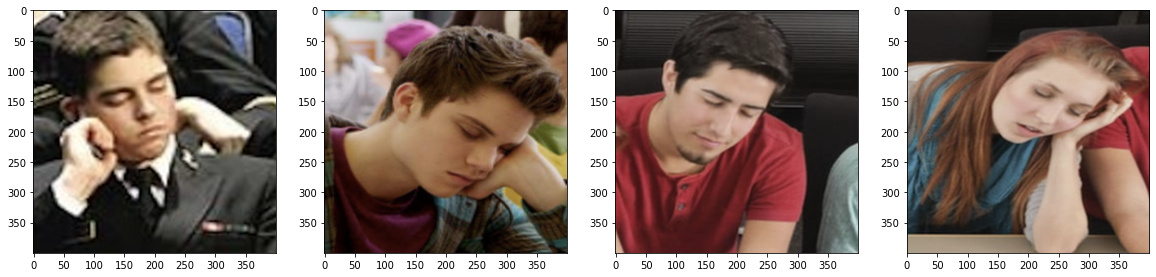

In [84]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 4 Data Augmentation

# 4.1 Moving the matching labels to train, test and valitation folders

In [85]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

In [86]:
#!pip install albumentations

In [78]:
import albumentations as alb

In [81]:
img = cv2.imread(os.path.join('data','train','images','2.png'))

In [82]:
img.shape

(400, 400, 3)

# 4.2 Setting up Augmentation 

In [83]:
augmentor = alb.Compose([alb.RandomCrop(width=360, height=360), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

# 4.3 Load One Image and annotation with opencv

In [84]:
img = cv2.imread(os.path.join('data','train','images','1.png'))

In [85]:
with open(os.path.join('data', 'train', 'labels', '1.json'), 'r') as f:
    label = json.load(f)

In [86]:
label['shapes'][0]['points']


[[40.5, 17.125], [239.875, 242.75]]

# 4.4 Extract coordinates and match the image resolution

In [87]:

coords=[0,0,0,0]

coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]
coords

[40.5, 17.125, 239.875, 242.75]

In [88]:
coords = list(np.divide(coords,[400,400,400,400]))

In [89]:
coords

[0.10125, 0.0428125, 0.5996875, 0.606875]

In [90]:
augmented = augmentor(image=img,bboxes=[coords],class_labels=['face'])

In [91]:
augmented['bboxes'][0][:2]

(0.0763888888888889, 0.32847222222222217)

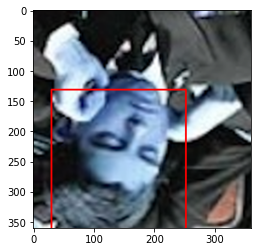

In [92]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [400,400]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [400,400]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])


# 4.5 Apply augmentation to all the images on train, test and val

In [93]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [400,400,400,400]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.png'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type
image must be numpy array type


# 4.6 Load Agumented Images to TF Pipeline

In [94]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.png', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [95]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.png', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [96]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.png', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [97]:
train_images.as_numpy_iterator().next()

array([[[0.34509805, 0.30588236, 0.29411766],
        [0.42352942, 0.38039216, 0.36078432],
        [0.49411765, 0.4392157 , 0.41568628],
        ...,
        [0.03921569, 0.05490196, 0.05490196],
        [0.04705882, 0.05882353, 0.05882353],
        [0.04705882, 0.05490196, 0.05490196]],

       [[0.24313726, 0.20784314, 0.19607843],
        [0.36862746, 0.32156864, 0.29803923],
        [0.4509804 , 0.40784314, 0.37254903],
        ...,
        [0.03137255, 0.04313726, 0.04705882],
        [0.02745098, 0.04313726, 0.04705882],
        [0.03137255, 0.04313726, 0.04705882]],

       [[0.29803923, 0.26666668, 0.24313726],
        [0.42745098, 0.38431373, 0.36078432],
        [0.47843137, 0.43137255, 0.4       ],
        ...,
        [0.03137255, 0.04705882, 0.04705882],
        [0.02352941, 0.02745098, 0.03529412],
        [0.02745098, 0.03921569, 0.03921569]],

       ...,

       [[0.04313726, 0.04313726, 0.05098039],
        [0.03921569, 0.03921569, 0.04705882],
        [0.03921569, 0

# 4.7 Load Labels of Agumented images to TF Pipeline

In [98]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [99]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [100]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [101]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [102]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.0125, 0.    , 0.5664, 0.5854], dtype=float16))

In [103]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2200, 2200, 300, 300, 240, 240)

# 4.8 Combine labels and images on train, test and val pipeline

In [104]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [105]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [106]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

# 4.9 View Images and annotations

In [107]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.0691  , 0.342   , 0.5776  , 0.9395  ],
        [0.1389  , 0.1205  , 0.7866  , 0.7817  ],
        [0.2827  , 0.      , 0.8193  , 0.6377  ],
        [0.2225  , 0.04932 , 0.851   , 0.761   ],
        [0.1694  , 0.00972 , 0.869   , 0.765   ],
        [0.3472  , 0.148   , 0.7676  , 0.745   ],
        [0.1337  , 0.002083, 0.762   , 0.714   ],
        [0.1694  , 0.07916 , 0.869   , 0.8345  ]], dtype=float16))

In [108]:
data_samples = train.as_numpy_iterator()

In [109]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


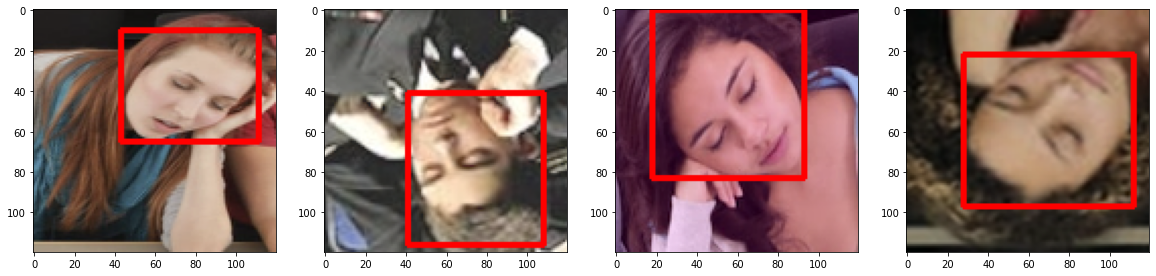

In [110]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 5 build NN 

In [111]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.applications import VGG16

In [112]:
vgg = VGG16(include_top=False)

In [113]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

# 5.1 build instance of the network

In [114]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dropout(0.4)(regress1)
    regress3 = Dense(4, activation='sigmoid')(regress2)
    facetracker = Model(inputs=input_layer, outputs=[class2, regress3])
    return facetracker

In [115]:
facetracker = build_model()

In [116]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_8[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_5 (GlobalM (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 512)          0           vgg16[0][0]                      
____________________________________________________________________________________________

# 5.2 Test the model

In [117]:
X, y = train.as_numpy_iterator().next()

In [118]:
X.shape

(8, 120, 120, 3)

In [119]:
classes, coords = facetracker.predict(X)

2022-05-30 12:02:41.079881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [120]:
classes, coords

(array([[0.68391335],
        [0.48561588],
        [0.66116315],
        [0.6713792 ],
        [0.63207555],
        [0.63574517],
        [0.63788944],
        [0.6436225 ]], dtype=float32),
 array([[0.38810152, 0.657971  , 0.5712268 , 0.51863164],
        [0.34658095, 0.5745072 , 0.52491647, 0.6120309 ],
        [0.3726771 , 0.59159297, 0.6059874 , 0.5476588 ],
        [0.34461468, 0.49685973, 0.5292617 , 0.4857937 ],
        [0.3452541 , 0.5217644 , 0.5370596 , 0.5703658 ],
        [0.40614012, 0.5653564 , 0.56713706, 0.588417  ],
        [0.39915317, 0.52107614, 0.446298  , 0.52440596],
        [0.30011013, 0.58387715, 0.53448063, 0.51368254]], dtype=float32))

# 5.3 Define losses and optimizers

In [121]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [122]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

# 5.4 Create localization loss and classification loss

In [123]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [124]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [125]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.7222066>

In [126]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.46454656>

In [127]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.7222066>

# 6. Train NN

In [128]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [129]:
model = FaceTracker(facetracker)

In [130]:
model.compile(opt, classloss, regressloss)

In [131]:
logdir='logs'

In [132]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

2022-05-30 12:02:53.952987: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-05-30 12:02:53.953028: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-05-30 12:02:53.954195: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [133]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2022-05-30 12:02:54.559230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  2/275 [..............................] - ETA: 1:01 - total_loss: 4.4600 - class_loss: 0.3567 - regress_loss: 4.2817 

2022-05-30 12:02:56.417069: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-05-30 12:02:56.417089: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  3/275 [..............................] - ETA: 1:10 - total_loss: 3.3884 - class_loss: 0.2733 - regress_loss: 3.2517

2022-05-30 12:02:56.708494: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-30 12:02:56.713470: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-05-30 12:02:56.717718: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_05_30_12_02_56
2022-05-30 12:02:56.719903: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_05_30_12_02_56/MacBook-Pro-de-julio.local.trace.json.gz
2022-05-30 12:02:56.724505: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_05_30_12_02_56
2022-05-30 12:02:56.724883: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_05_30_12_02_56/MacBook-Pro-de-julio.local.memory_profile.json.gz
202

275/275 [==============================] - ETA: 0s - total_loss: 0.3308 - class_loss: 0.0075 - regress_loss: 0.3270

2022-05-30 12:03:42.167357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


275/275 [==============================] - 50s 173ms/step - total_loss: 0.3299 - class_loss: 0.0075 - regress_loss: 0.3262 - val_total_loss: 0.3569 - val_class_loss: 1.0452e-04 - val_regress_loss: 0.3569
Epoch 2/10
275/275 [==============================] - 49s 172ms/step - total_loss: 0.0902 - class_loss: 1.3225e-04 - regress_loss: 0.0901 - val_total_loss: 0.2855 - val_class_loss: 1.0411e-05 - val_regress_loss: 0.2854
Epoch 3/10
275/275 [==============================] - 49s 174ms/step - total_loss: 0.0528 - class_loss: 3.9024e-05 - regress_loss: 0.0528 - val_total_loss: 0.2101 - val_class_loss: 6.9822e-06 - val_regress_loss: 0.2101
Epoch 4/10
275/275 [==============================] - 49s 172ms/step - total_loss: 0.0381 - class_loss: 2.0610e-05 - regress_loss: 0.0381 - val_total_loss: 0.2439 - val_class_loss: 2.4995e-06 - val_regress_loss: 0.2439
Epoch 5/10
275/275 [==============================] - 49s 173ms/step - total_loss: 0.0329 - class_loss: 1.0882e-05 - regress_loss: 0.0329 -

# 6.1 plot performance 

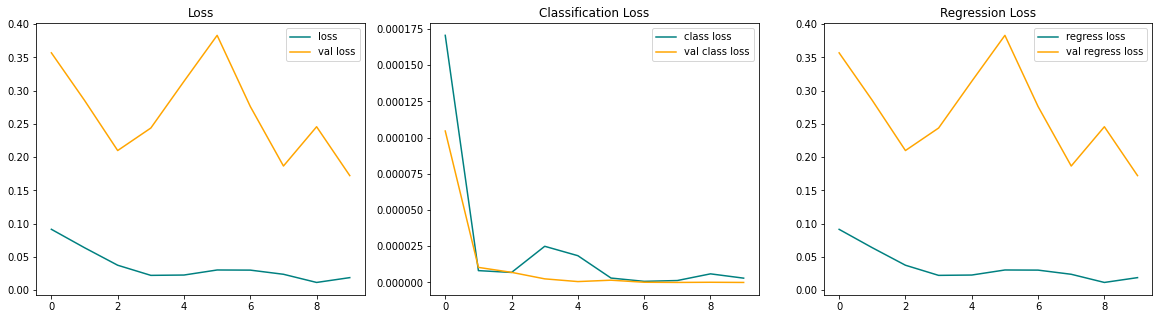

In [134]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 6.2 make predictions on images 

In [135]:
test_data = test.as_numpy_iterator()

In [136]:
test_sample = test_data.next()

In [137]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


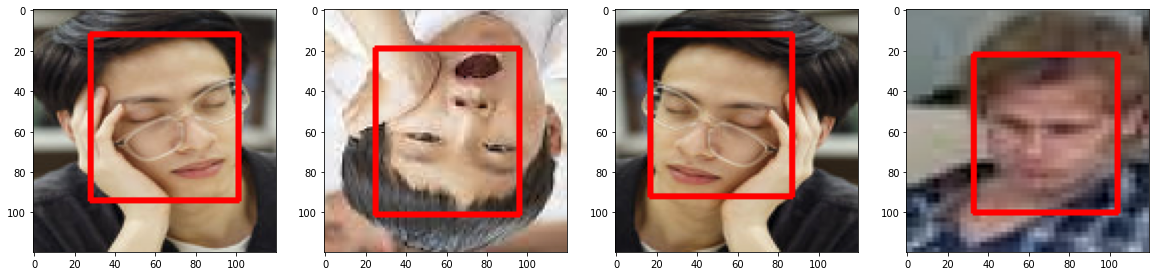

In [138]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# 6.4 Save the model 

In [139]:
from tensorflow.keras.models import load_model

In [140]:
facetracker.save('facetracker.h5')

In [141]:
facetracker = load_model('facetracker.h5')

# 6.5 Real time prediction

In [142]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    check, frame = cap.read()
    frame = frame[300:700, 300:700,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [400,400]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [400,400]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [400,400]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [400,400]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [400,400]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('video', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

2022-05-30 12:11:49.875646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


# 6.6 Testing on another image 

# 6.6.1 Reescaling the image

In [143]:
im = Image.open('test_face.jpeg')
f, e = os.path.splitext('test_face.jpeg')
imResize = im.resize((400,400), Image.ANTIALIAS)
imResize.save(f + '.jpeg', 'JPEG', quality=90)

NameError: name 'Image' is not defined

# 6.6.2 Testing

In [ ]:

#frame = frame[500:700, 500:700,:]
frame = cv2.imread('test_face.jpeg', cv2.COLOR_BGR2RGB)
rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
resized = tf.image.resize(rgb, (120,120))

yhat = facetracker.predict(np.expand_dims(resized/255,0))
sample_coords = yhat[1][0]

if yhat[0] > 0.5: 
    # Controls the main rectangle
    cv2.rectangle(frame, 
                  tuple(np.multiply(sample_coords[:2], [400,400]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [400,400]).astype(int)), 
                        (255,0,0), 2)
    # Controls the label rectangle
    cv2.rectangle(frame, 
                  tuple(np.add(np.multiply(sample_coords[:2], [400,400]).astype(int), 
                                [0,-30])),
                  tuple(np.add(np.multiply(sample_coords[:2], [400,400]).astype(int),
                                [80,0])), 
                        (255,0,0), -1)

    # Controls the text rendered
    cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [400,400]).astype(int),
                                           [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
cv2.imwrite('video.jpg', frame)

True

/var/folders/g0/6kw6vltn32x9ytl0jsj6sh5h0000gn/T/ipykernel_43455/3979131350.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imResize = im.resize((400,400), Image.ANTIALIAS)
